# Embeddings Demonstration - Product Attribute Extraction

This notebook demonstrates how to use embeddings and retrieval augemented generation (RAG) approach to fill-in attributes for products at scale when similar products exists in the catalogue.




<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/guruvittal/codesamples/blob/main/Embeddings_Demo.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/guruvittal/codesamples/blob/main/Embeddings_Demo.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/guruvittal/codesamples/main/Embeddings_Demo.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>

# Setup

### Install Dependencies (If Needed)

The list `packages` contains tuples of package import names and install names. If the import name is not found then the install name is used to install quitely for the current user.

In [3]:
# tuples of (import name, install name)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('google.cloud.bigquery', 'google-cloud-bigquery[pandas]'),
    ('opendatasets','opendatasets'),
    ('jsonpickle','jsonpickle')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U --user



import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [4]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Authenticate

If you are using Colab, you will need to authenticate yourself first. The next cell will check if you are currently using Colab, and will start the authentication process.

If you are using Vertex AI Workbench, you will not require additional authentication.

In [5]:
import sys

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()

## Helper files



### Embeddings - Request & Response Methods

Generating embeddings from the multimodal model requires a few function calls to be enabled.

In [6]:
import base64
from google.cloud import aiplatform
from google.protobuf import struct_pb2
from functools import cache
import time
import typing
import logging


class EmbeddingResponse(typing.NamedTuple):
  text_embedding: typing.Sequence[float]
  image_embedding: typing.Sequence[float]


class EmbeddingPredictionClient:
  """Wrapper around Prediction Service Client."""
  def __init__(self, project : str,
    location : str = "us-central1",
    api_regional_endpoint: str = "us-central1-aiplatform.googleapis.com"):
    client_options = {"api_endpoint": api_regional_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    self.client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
    self.location = location
    self.project = project

  def get_embedding(self, text : str = None, image_path : str = None):
    """image_path can be a local path or a GCS URI."""
    if not text and not image_path:
      raise ValueError('At least one of text or image_bytes must be specified.')

    instance = struct_pb2.Struct()

    if text:
      if len(text) > 1024:
        logging.warning('Text must be less than 1024 characters. Truncating text.')
        text = text[:1024]
      instance.fields['text'].string_value = text

    if image_path:
      image_struct = instance.fields['image'].struct_value
      if image_path.lower().startswith('gs://'):
        image_struct.fields['gcsUri'].string_value = image_path
      else:
        with open(image_path, "rb") as f:
          image_bytes = f.read()
        encoded_content = base64.b64encode(image_bytes).decode("utf-8")
        image_struct.fields['bytesBase64Encoded'].string_value = encoded_content

    instances = [instance]
    endpoint = (f"projects/{self.project}/locations/{self.location}"
      "/publishers/google/models/multimodalembedding@001")
    try:
      response = self.client.predict(endpoint=endpoint, instances=instances)

      text_embedding = None
      if text:
        text_emb_value = response.predictions[0]['textEmbedding']
        text_embedding = [v for v in text_emb_value]

      image_embedding = None
      if image_path:
        image_emb_value = response.predictions[0]['imageEmbedding']
        image_embedding = [v for v in image_emb_value]

      return EmbeddingResponse(
        text_embedding=text_embedding,
        image_embedding=image_embedding)
    except Exception as e:
      print(e)
      return None

@cache
def get_client(project):
  return EmbeddingPredictionClient(project)


def embed(project,text,image_path=None):
  client = get_client(project)
  start = time.time()
  response = client.get_embedding(text=text, image_path=image_path)
  end = time.time()
  print('Embedding Time: ', end - start)
  return response

### Big Query - Helper Methods

In [7]:
from google.cloud import bigquery

def create_table(client, table_id):
    table = bigquery.Table(table_id)
    table = client.create_table(table,exists_ok=True)  # Make an API request
    print(
        "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
    )
def upload_df_into_bq(client, table_id, df):
    #df.to_gbq(table_id, PROJECT, if_exists='replace', progress_bar=True)
    job_config = bigquery.LoadJobConfig()
    job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE
    #job_config.skip_leading_rows = 1
    job_config.autodetect = True
    job_config.source_format=bigquery.SourceFormat.CSV

    try:
      job = client.load_table_from_dataframe(df, table_id, job_config=job_config)
      job.result()
      print(
        "Uploaded dataframe into table {}.{}".format(PROJECT, table_id)
      )
    except Exception as error:
      print("Error:", error)



### Cloud Storage - Helper Methods

In [8]:

from google.cloud import storage

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    #generation_match_precondition = 0
    blob.upload_from_filename(source_file_name)
    print(f"File {source_file_name} uploaded to {destination_blob_name}.")

def download_blob(bucketname):
    """Downloads a blob from the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucketname)

    # List all objects that satisfy the filter.
    blobs=bucket.list_blobs()

    if os.path.isdir(bucketname):
      print("Directory exists:", bucketname)
    else:
      os.mkdir(bucketname)
      print("Directory '% s' created" % bucketname)
    i = 0
    for blob in blobs:
      i=i+1
      destination_uri = f"{bucketname}/{blob.name}"
      blob.download_to_filename(destination_uri)
    print(f"Blobs downloaded: {i}")



## Ingest Reference Dataset

We will be using a public dataset on Kaggle for this demonstration. After downloading the data, save the file locally or on a cloud storage bucket for any future reference.

In [10]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/PromptCloudHQ/flipkart-products/download")
!gsutil cp /content/flipkart-products/flipkart_com-ecommerce_sample.csv gs://pimdata/

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mitguru
Your Kaggle Key: ··········


100%|██████████| 5.50M/5.50M [00:00<00:00, 38.4MB/s]

Copying file:///content/flipkart-products/flipkart_com-ecommerce_sample.csv [Content-Type=text/csv]...
\ [1 files][ 36.4 MiB/ 36.4 MiB]                                                
Operation completed over 1 objects/36.4 MiB.                                     


In [11]:
import pandas as pd
full_ds = pd.read_csv('flipkart-products/flipkart_com-ecommerce_sample.csv')


## Reference parameters & Constants

In [12]:
# GCP
PROJECT = "argolis-project-340214"   # @param {type: "string"}
LOCATION = 'us-central1' # @param {type: "string"}

# BigQuery
PRODUCT_TABLE = 'argolis-project-340214.PIMDemo.KaggleData' # @param {type: "string"}


# Data Exploration

In [13]:
full_ds.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [16]:
pd.options.display.max_colwidth = 1000
print(full_ds.loc[13855,["description"]])

description    Numero Uno Solid Mens Round Neck T-Shirt                         Price: Rs. 758\t\t\t\t\t\t\tThis casual shirt was once worn layered with formal clothes has now movedon with a fashion statement of its own. Evoking a sense of effortless casualstyle this shirt is the perfect pick for your weekend wardrobe. Crafted from cotton it is cut with full sleeves and a round neck that add to the laid back look of this design.Wear yours with a pair of shorts or rugged denims.Did you know?There are over 2 million t-shirts sold every year!Full sleeves::Round neck::Cotton 1X1 RIB::Hand wash cold::Use mild detergent::Wash inside out::Wash dark colours separately::Do not bleach::Do not soak::Do not wring or squeeze::Medium iron::Do not iron on printThis casual shirt was once worn layered with formal clothes has now movedon with a fashion statement of its own. Evoking a sense of effortless casualstyle this shirt is the perfect pick for your weekend wardrobe. Crafted from cotton it is cut w

In [15]:
full_ds["description"] = full_ds["description"].str.replace('"', '')
full_ds["description"] = full_ds["description"].str.replace("'", "")
full_ds["description"] = full_ds["description"].str.replace('\n', '')
full_ds["description"] = full_ds["description"].str.replace('\r', '')


# Data Ingestion

## Ingest data to Big Query

In [ ]:
client = bigquery.Client(PROJECT)

create_table(client, PRODUCT_TABLE)

upload_df_into_bq(client, PRODUCT_TABLE, full_ds)


# Generate Embeddings for Dataset & Store in Big Query

## Update Big Query Schema to store embeddings

In [ ]:
table = client.get_table(PRODUCT_TABLE)
original_schema = table.schema
new_schema = original_schema[:]  # Creates a copy of the schema.
new_schema.append(bigquery.SchemaField('text_embedding', 'FLOAT', mode='REPEATED'))
new_schema.append(bigquery.SchemaField('image_embedding', 'FLOAT', mode='REPEATED'))

table.schema = new_schema
table = client.update_table(table, ["schema"])  # Make an API request.

if len(table.schema) == len(original_schema) + 2 == len(new_schema):
    print("Two new columns have been added.")
else:
    print("Something went wrong.")

Two new columns have been added.


## Load Big Query Table to a Dataframe

In [ ]:
## Query against Big Query Table to extract a section of items for building vector space

client = bigquery.Client(PROJECT)

# Only fetch rows with no embedding. Bypass this query to update all rows
query = f"""
SELECT
  uniq_id,
  description,
  image
FROM
  `{PRODUCT_TABLE}`
order by uniq_id asc

"""
query_job = client.query(query)
query_job.result()
destination = query_job.destination
rows = client.list_rows(destination, max_results=100)
print(rows.total_rows, ": Total no. of rows stored in Big Query")

## Store Query Outut to a dataframe

df = rows.to_dataframe()

for index, row in df.iterrows():
  print(index, row['uniq_id'], row['description'])

## Generate Embeddings & Store in Big Query + Download Images & Store in Cloud Storage

In [ ]:
import urllib
import os
import ast


#Set to 1 to clean up stragglers if rows not a multiple of batch_size
BATCH_SIZE = 10

text_embeddings, image_embeddings, ids = [], [], []


for index, row in df.iterrows():
  ImageList = ast.literal_eval(row["image"])
  print(f'\n{index+1}: {row["description"]}\nimage_uri:{ImageList[0]}')
  blobname = row["uniq_id"]+".jpg"
  try:
    urllib.request.urlretrieve(ImageList[0], "my_file.jpg")
  except Exception as error:
    print("Index:" , index, "Error getting image file - skipping record:", ImageList[0])
    continue
  upload_blob("pimproductimages","my_file.jpg",blobname)
  try:
    res = embed(PROJECT,row["description"][:900],"/content/my_file.jpg") #API claims to supports up to 1024 chars but in practice get errors for shorter lengths
    print(res.text_embedding[:5])
    print(res.image_embedding[:5])
  except Exception as error:
    print("Index:" , index, "Error provided image is not valid:", ImageList[0])
    continue

  text_embeddings.append(res.text_embedding)
  image_embeddings.append(res.image_embedding)
  ids.append(row["uniq_id"])
  if len(text_embeddings) == BATCH_SIZE:
    print(f'\nBATCHING {BATCH_SIZE} UPDATES TO BQ...')
    query = f"""
        UPDATE
          `{PRODUCT_TABLE}`
        SET
          text_embedding = (
            CASE
              {''.join([f'WHEN uniq_id = "{ids[i]}" THEN {text_embeddings[i]}{chr(10)}' for i in range(len(ids))])}
            END),
          image_embedding = (
            CASE
              {''.join([f'WHEN uniq_id = "{ids[i]}" THEN {image_embeddings[i]}{chr(10)}' for i in range(len(ids))])}
            END)
        WHERE
          uniq_id IN {str(ids).replace('[','(').replace(']',')')}
    """
    start = time.time()
    query_job = client.query(query)
    query_job.result()  # Wait for the query to complete.
    end = time.time()
    print('BQ Update Time: ', end - start)
    #text_embeddings, image_embeddings, ids = [], [], []


## Download Images from Cloud Storage to Local


In [20]:
from google.cloud import storage

import os

#Download images from bucket 'pimproductimages' to local folder: 'pimproductimages'

download_blob("pimproductimages")

Directory 'pimproductimages' created
Blobs downloaded: 94


# Publish Embeddings in a JSON format on Cloud Storage

### Store embeddings in a JSON file

In [21]:
from tqdm import tqdm
import json
import tempfile

# Create temporary file to write embeddings to
embeddings_file = tempfile.NamedTemporaryFile(suffix=".json", delete=False)

BATCH_SIZE = 1000
print(len(ids))
with open(embeddings_file.name, "a") as f:
    for i in tqdm(range(0, len(ids), BATCH_SIZE)):
      print("Record:", i)
      # Append to file
      embeddings_formatted = [
            json.dumps(
                {
                    "id": str(id)+"_T",
                    "embedding": [str(value) for value in embedding],
                }
            )
            + "\n"
            for id, embedding in zip(ids, text_embeddings)
            if embedding is not None
      ]
      f.writelines(embeddings_formatted)

with open(embeddings_file.name, "a") as f:
    for i in tqdm(range(0, len(ids), BATCH_SIZE)):
      print("Record:", i)
      # Append to file
      embeddings_formatted = [
            json.dumps(
                {
                    "id": str(id)+"_I",
                    "embedding": [str(value) for value in embedding],
                }
            )
            + "\n"
            for id, embedding in zip(ids, image_embeddings)
            if embedding is not None
      ]
      f.writelines(embeddings_formatted)

94


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


Record: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Record: 0


100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


## Move JSON file to Cloud Storage bucket

In [24]:

# Bucket name for storing embeddings
EMBEDDINGS_URI = "gs://pimembeddings/"

print(f"Length - Image Embeddings:{len(image_embeddings)}, Text Embeddings:{len(text_embeddings)}, Ids:{len(ids)}")
!echo `gsutil ls gs://pimproductimages | wc -l` images
!wc -l {embeddings_file.name}

!gcloud config set project $PROJECT
print (PROJECT)

!gsutil ls gs://pimembeddings/
!gsutil rm  gs://pimembeddings/*

! gsutil cp {embeddings_file.name} {EMBEDDINGS_URI}

Length - Image Embeddings:94, Text Embeddings:94, Ids:94
94 images
188 /tmp/tmpg3xt1mvm.json
Updated property [core/project].
argolis-project-340214
CommandException: No URLs matched: gs://pimembeddings/*
Copying file:///tmp/tmpg3xt1mvm.json [Content-Type=application/json]...
- [1 files][  4.2 MiB/  4.2 MiB]                                                
Operation completed over 1 objects/4.2 MiB.                                      


# Vector Store using Matching Engine




## Create Matching Engine Index

In [ ]:
# Initiate Vertex AI project
from google.cloud import aiplatform
import vertexai
vertexai.init(project=PROJECT, location="us-central1")

# Bucket name for storing embeddings
EMBEDDINGS_URI = "gs://pimembeddings/"

# Create Index with Tree AH algorithm with Cosine distance for proximity measure

tree_ah_index = aiplatform.MatchingEngineIndex.create_tree_ah_index(
    display_name='PIM_multimodal_batch_tree_cosine',
    contents_delta_uri=EMBEDDINGS_URI,
    dimensions=1408,
    approximate_neighbors_count=150,
    distance_measure_type="COSINE_DISTANCE",
    leaf_node_embedding_count=500,
    leaf_nodes_to_search_percent=7,
    description='Based on ~92 product listings for which we have both a description and image',
)

INDEX_RESOURCE_NAME = tree_ah_index.resource_name

print(INDEX_RESOURCE_NAME)

## Create Index Endpoint

In [ ]:
# Retrieve the project number
PROJECT_NUMBER = !gcloud projects list --filter="PROJECT_ID:'{PROJECT}'" --format='value(PROJECT_NUMBER)'
PROJECT_NUMBER = PROJECT_NUMBER[0]

# Define VPC Network to host endpoint if public endpoint is not enabled
VPC_NETWORK = "matching-engine-vpc-network"
VPC_NETWORK_FULL = "projects/{}/global/networks/{}".format(PROJECT_NUMBER, VPC_NETWORK)
VPC_NETWORK_FULL


# Instantiate End point
DISPLAY_NAME = "PIM_multimodal_batch_tree_cosine"
my_index_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
    display_name=DISPLAY_NAME,
    description=DISPLAY_NAME,
    public_endpoint_enabled=True
#    network=VPC_NETWORK_FULL,
)

## Deploy index to Endpoint

In [ ]:
DEPLOYED_INDEX_ID = "PIM_Embeddings_Index"
my_index_endpoint = my_index_endpoint.deploy_index(
    index=tree_ah_index, deployed_index_id=DEPLOYED_INDEX_ID
)

my_index_endpoint.deployed_indexes

## Validating Matching Engine Index & Endpoint

In [25]:
!gcloud ai indexes list \
  --project="argolis-project-340214" \
  --region="us-central1"

!gcloud ai index-endpoints list --project="argolis-project-340214" --region="us-central1"

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
---
createTime: '2024-01-27T11:19:36.581229Z'
deployedIndexes:
- deployedIndexId: PIM_Embeddings_Index
  indexEndpoint: projects/742458474659/locations/us-central1/indexEndpoints/3967851591620362240
description: Based on ~92 product listings for which we have both a description and
  image
displayName: PIM_multimodal_batch_tree_cosine
encryptionSpec: {}
etag: AMEw9yMmZx4Jy5BNdSu19Stj_-jtuCfVeyI1AEF2O3AEMugwxZ2DZiuhZLPiaV6gj04=
indexStats:
  shardsCount: 1
  vectorsCount: '184'
indexUpdateMethod: BATCH_UPDATE
metadata:
  config:
    algorithmConfig:
      treeAhConfig:
        leafNodeEmbeddingCount: '500'
        leafNodesToSearchPercent: 7
    approximateNeighborsCount: 150
    dimensions: 1408
    distanceMeasureType: COSINE_DISTANCE
    shardSize: SHARD_SIZE_MEDIUM
metadataSchemaUri: gs://google-cloud-aiplatform/schema/matchingengine/metadata/nearest_neighbor_search_1.0.0.yaml
name: projects/742458474659/locations/us-ce

## Identifying the Endpoint

In [33]:

# Vertex Vector Store
ENDPOINT_ID = '3967851591620362240'
DEPLOYED_INDEX_ID = 'PIM_Embeddings_Index'
NUM_NEIGHBORS = 7 # Fetches NUM_NEIGBHORS for both text and image embeddings


In [27]:
my_index_endpoint = aiplatform.MatchingEngineIndexEndpoint(
    index_endpoint_name=ENDPOINT_ID,
    project=PROJECT,
    location=LOCATION
)

# Validating Generated Embeddings: Rubber meets the road

## Visualizing the context vector space

Skipping: /content/pimproductimages/00234f1417b5b1dc65feb088cf612762.jpg Message: [Errno 2] No such file or directory: '/content/pimproductimages/00234f1417b5b1dc65feb088cf612762.jpg'
Skipping: /content/pimproductimages/0024c8c4636f633a96e6b032acc179c5.jpg Message: [Errno 2] No such file or directory: '/content/pimproductimages/0024c8c4636f633a96e6b032acc179c5.jpg'
Skipping: /content/pimproductimages/00353b508276e6f860b5760654a0bb65.jpg Message: [Errno 2] No such file or directory: '/content/pimproductimages/00353b508276e6f860b5760654a0bb65.jpg'


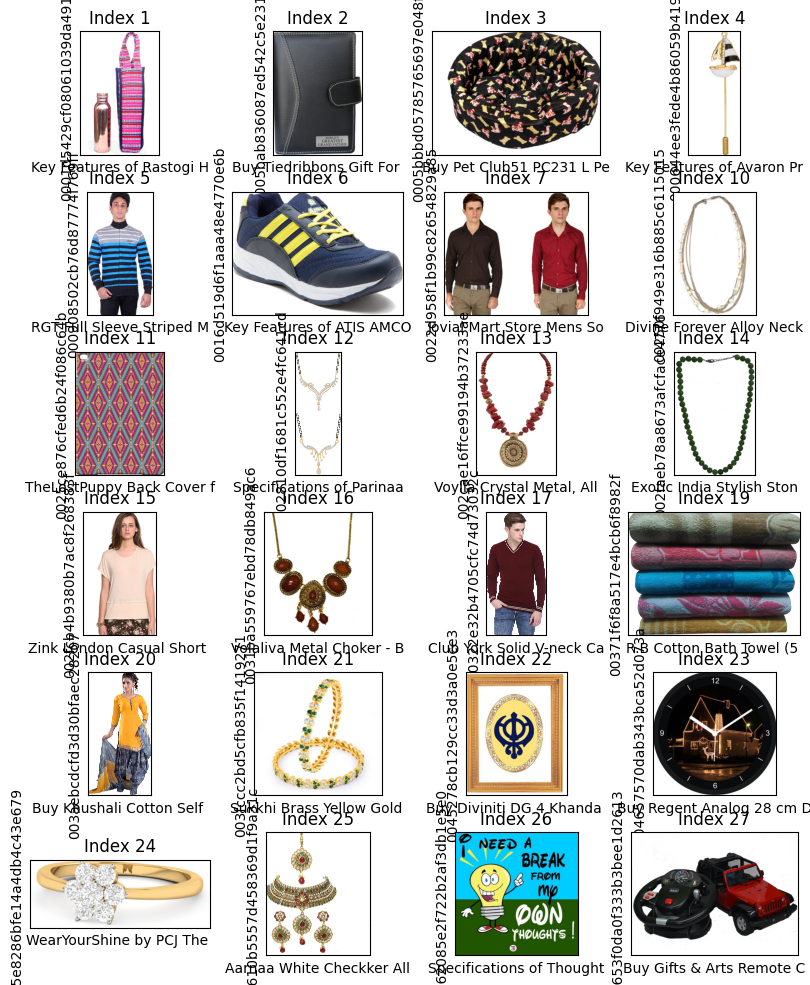

In [29]:
from PIL import Image

from io import BytesIO
import matplotlib.pyplot as plt
import math
import requests

# Calculate the number of rows and columns needed to display the images
num_cols = 4
#num_rows = math.ceil(len(df) / num_cols)
num_rows = 6
num_images = 0
num_images_max = num_cols * num_rows

# Create a grid of subplots to display the images
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))

# Loop through the top max_images images and display them in the subplots
for index, row in df.iterrows():
    if num_images > num_images_max - 1:
      continue
    #print("Processing Image:", num_images)

    id = row["uniq_id"]
    image_path = f"/content/pimproductimages/{id}.jpg"
    try:
      image = Image.open(image_path)
    except Exception as error:
      print("Skipping:", image_path, "Message:", error)
      continue
    row_description = row["description"]

    # Calculate the row and column index for the current image
    row_idx = num_images // num_cols
    col_idx = num_images % num_cols


    # Display the image in the current subplot
    axs[row_idx, col_idx].imshow(image, cmap="gray")
    #axs[row_idx,col_idx].set_url(ObjectImage)

    # Set the title of the subplot to the image index and score
    axs[row_idx, col_idx].set_title(f"Index {index+1}")  # noqa
    axs[row_idx, col_idx].set_xlabel(f"{row_description[:25]}")
    axs[row_idx, col_idx].set_ylabel(f"{id[:25]}")

    # Remove ticks from the subplot
    axs[row_idx, col_idx].set_xticks([])
    axs[row_idx, col_idx].set_yticks([])
    num_images = num_images + 1

# Adjust the spacing between subplots and display the plot
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

## Test Case 1: Can Vector Search find products similar to a T Shirt?

### Generate text and image embedding for a T Shirt image:

Downloaded
Embedding Time:  0.5714395046234131
EmbeddingResponse(text_embedding=[-0.0293039344, -0.00232049893, 0.00605373085, 0.00107204716, -0.024456203, -0.00126630277, -0.0151899448, 0.0197651275, 0.0100964671, -0.00496560521, 0.0138815828, 0.012378105, 0.013151926, 0.0148012144, 0.0100897122, -0.018360354, 0.0053653568, 0.00770822261, 0.0439976156, 0.00999984145, -0.0704146847, 0.0171322618, -0.0202870015, -0.0244493522, 0.0185379982, -0.0152224107, -0.021521721, -0.0200913362, 0.0175339673, -0.0276392605, 0.0191063844, 0.0327739567, 0.00396719808, 0.00970290136, 0.0105153145, -0.0115055339, 0.000398866046, 0.00556085, 0.00384731335, 0.0113707539, -0.0236835517, -0.0141441599, 0.0279574, 0.0164017025, 0.0139408559, 0.00177109952, 0.0055649248, -0.0166570824, 0.0151261678, 0.0399213657, 0.0397564657, -0.00815665, 0.0468573831, 0.00615471322, -0.0514930263, -0.0140118981, -0.000571500277, -0.00636817841, -0.0256742612, -0.0113694482, -0.00440328522, 0.024574846, 0.00769807911, 0.003

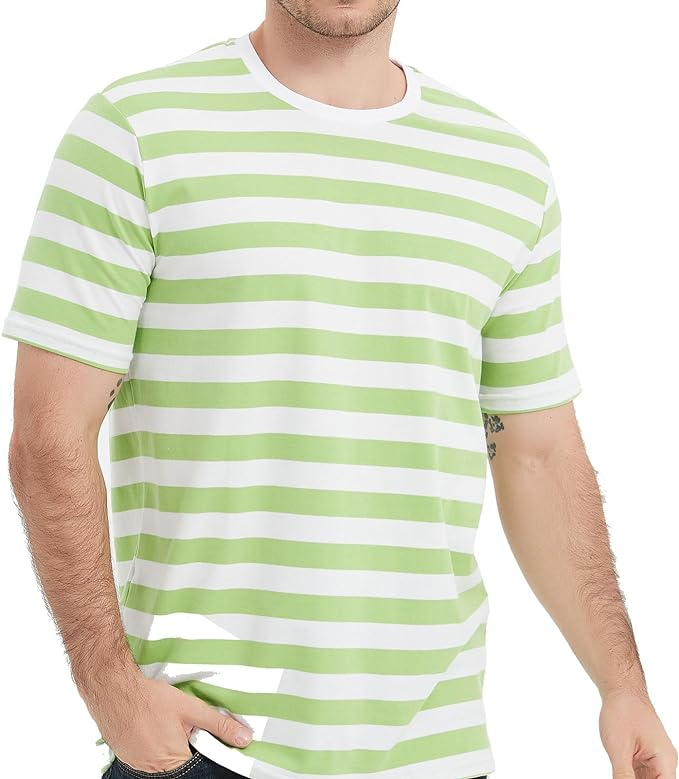

In [31]:
import urllib

Description = "Mens Striped T Shirt"
IMAGE_URL = "https://m.media-amazon.com/images/I/71PK3-SHCJL._AC_SX679_.jpg"
urllib.request.urlretrieve(IMAGE_URL, "my_file.jpg")
print("Downloaded")
image_path = "/content/my_file.jpg"
emb = embed(text=Description,image_path=image_path, project=PROJECT)
print(emb)
Image.open(image_path)


### Generate Nearest Neighbors for Test Case 1

In [34]:
response = my_index_endpoint.find_neighbors(
    deployed_index_id=DEPLOYED_INDEX_ID,
    queries=[emb.text_embedding,emb.image_embedding],
    num_neighbors=NUM_NEIGHBORS,
)

response

[[MatchNeighbor(id='00f713ac460e7e07e8aba53ee9ef3b47_T', distance=0.397945761680603),
  MatchNeighbor(id='000908502cb76d87774f769ff431606d_T', distance=0.4425356388092041),
  MatchNeighbor(id='009f4125dc951d217243adb10adacb84_T', distance=0.4759258031845093),
  MatchNeighbor(id='0097326ca37aee0783bce28eedb8743a_T', distance=0.47929322719573975),
  MatchNeighbor(id='00d84a518e0550612fcfcba3b02b6255_T', distance=0.5075322985649109),
  MatchNeighbor(id='009245c1f782156562d519de64101cfe_T', distance=0.5153929591178894),
  MatchNeighbor(id='00c06f5ee1687ba7e94fe4b27baf3ce3_T', distance=0.5176573991775513)],
 [MatchNeighbor(id='00f713ac460e7e07e8aba53ee9ef3b47_I', distance=0.3702409863471985),
  MatchNeighbor(id='002fcb4b9380b7ac8f268383fc6a47c3_I', distance=0.45621436834335327),
  MatchNeighbor(id='00e78be6c8c6451c233068f016d07e73_I', distance=0.4590541124343872),
  MatchNeighbor(id='00322e32b4705cfc74d73032c39a44ab_I', distance=0.46886909008026123),
  MatchNeighbor(id='000908502cb76d87774f

### Visualize Nearest Neighbors for Test Case 1

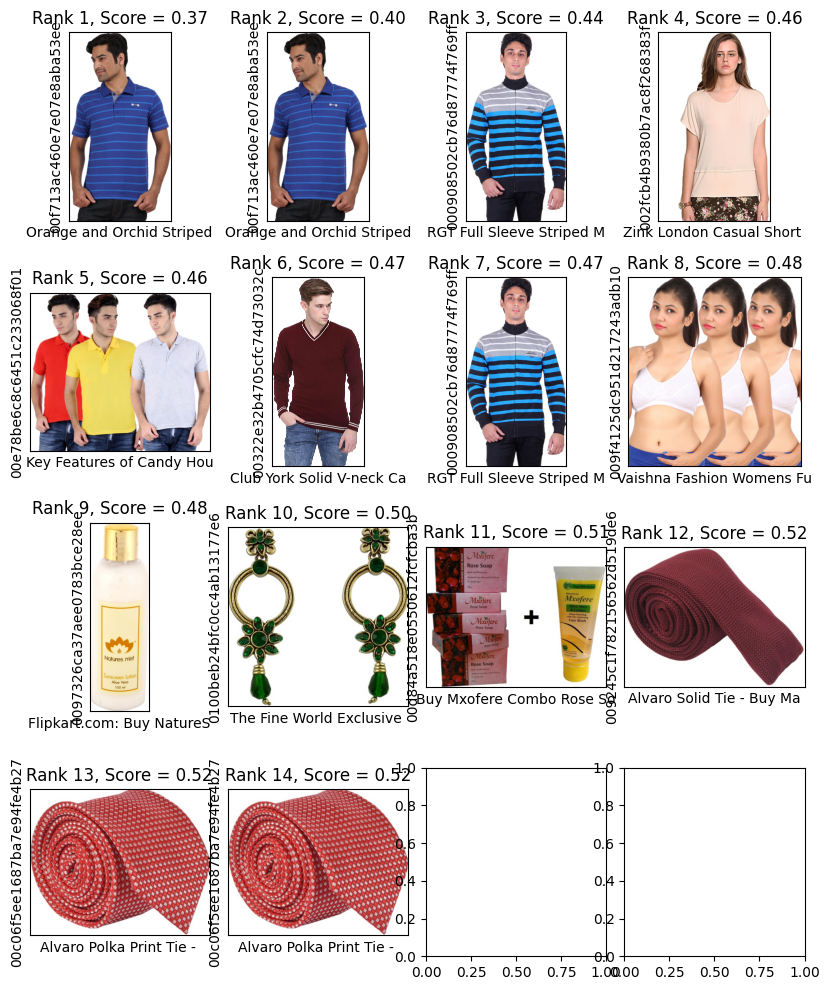

In [35]:
import matplotlib.pyplot as plt
import math
import requests
import ast


def left(s, amount):
    return s[:amount]

neighbors = []

for neighborlist in response:
  for neighbor in neighborlist:
    neighbors.append(neighbor)

# Sort images and scores by descending order of scores and select the top max_images
#sorted_data = sorted(response.nearest_neighbors[0].neighbors, key=lambda x: x.distance, reverse=True)
sorted_data = sorted(neighbors, key=lambda x: x.distance, reverse=False)


# Calculate the number of rows and columns needed to display the images
num_cols = 4
num_rows = math.ceil(len(sorted_data) / num_cols)


# Create a grid of subplots to display the images
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))

# Loop through the top max_images images and display them in the subplots
for i, datalist in enumerate(sorted_data):
    #id = left(datalist.datapoint.datapoint_id,len(datalist.datapoint.datapoint_id)-2)
    id = left(datalist.id,len(datalist.id)-2)
    image_path = ast.literal_eval(df["image"][df["uniq_id"]== id].iloc[0])[0]
    Dist = datalist.distance
    neighbor_description = df["description"][df["uniq_id"]== id].iloc[0]

    # Calculate the row and column index for the current image
    row_idx = i // num_cols
    col_idx = i % num_cols

        # Check if image_path is a remote URL
    if image_path.startswith("http://") or image_path.startswith("https://"):
        ObjectImage = requests.get(image_path)
        image = Image.open(BytesIO(ObjectImage.content))
    else:
        image = Image.open(image_path)

    # Display the image in the current subplot
    axs[row_idx, col_idx].imshow(image, cmap="gray")

    # Set the title of the subplot to the image index and score
    axs[row_idx, col_idx].set_title(f"Rank {i+1}, Distance = {Dist:.2f}")  # noqa
    #axs[row_idx, col_idx].annotate(f"{neighbor_description[:10]}", (1, 1), fontsize=10)
    axs[row_idx, col_idx].set_xlabel(f"{neighbor_description[:25]}")
    axs[row_idx, col_idx].set_ylabel(f"{id[:25]}")


    # Remove ticks from the subplot
    axs[row_idx, col_idx].set_xticks([])
    axs[row_idx, col_idx].set_yticks([])

# Adjust the spacing between subplots and display the plot
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()


## Test Case 2: Can Vector Search find products similar to a pendant?

### Generate Text & Image embeddings for a pendant

Downloaded
Embedding Time:  0.7511258125305176
EmbeddingResponse(text_embedding=[0.0370233916, -0.00808193628, -0.0209438149, -0.0433274, 0.0316030607, -0.0391463377, -0.00745698204, -0.0217967238, -0.00849461183, 0.0627604946, 0.00757417968, -0.0249342397, 0.0120817451, 0.0247162953, -0.0121777067, 0.0102890944, 0.0163867176, -0.0118765701, 0.0496818759, -0.0330803059, -0.0289768483, -0.0032994647, 0.013361101, -0.00923769921, -0.0101858759, 0.0344768204, -0.0322371684, -0.0123647144, 0.0282008871, 0.0338445604, 0.0245556254, 0.0206772704, 0.0302633941, 0.00188048789, -0.0393045172, 0.00111074082, -0.00923227798, 0.00336522609, -0.0138749937, -0.0198163874, -0.00619561411, 0.00625251606, -0.0108714961, 0.0317136832, -0.0103898356, 0.00273456122, -0.0232051443, -0.00750749139, 0.00268016546, 0.0854833573, 0.0147816297, -0.0503697693, 0.0053219609, 0.0177739616, -0.0239310134, -0.0706728846, 0.0184057932, 0.000819974637, 0.0339308493, 0.00111220079, 0.0262576714, 0.0236786325, 0.0045179

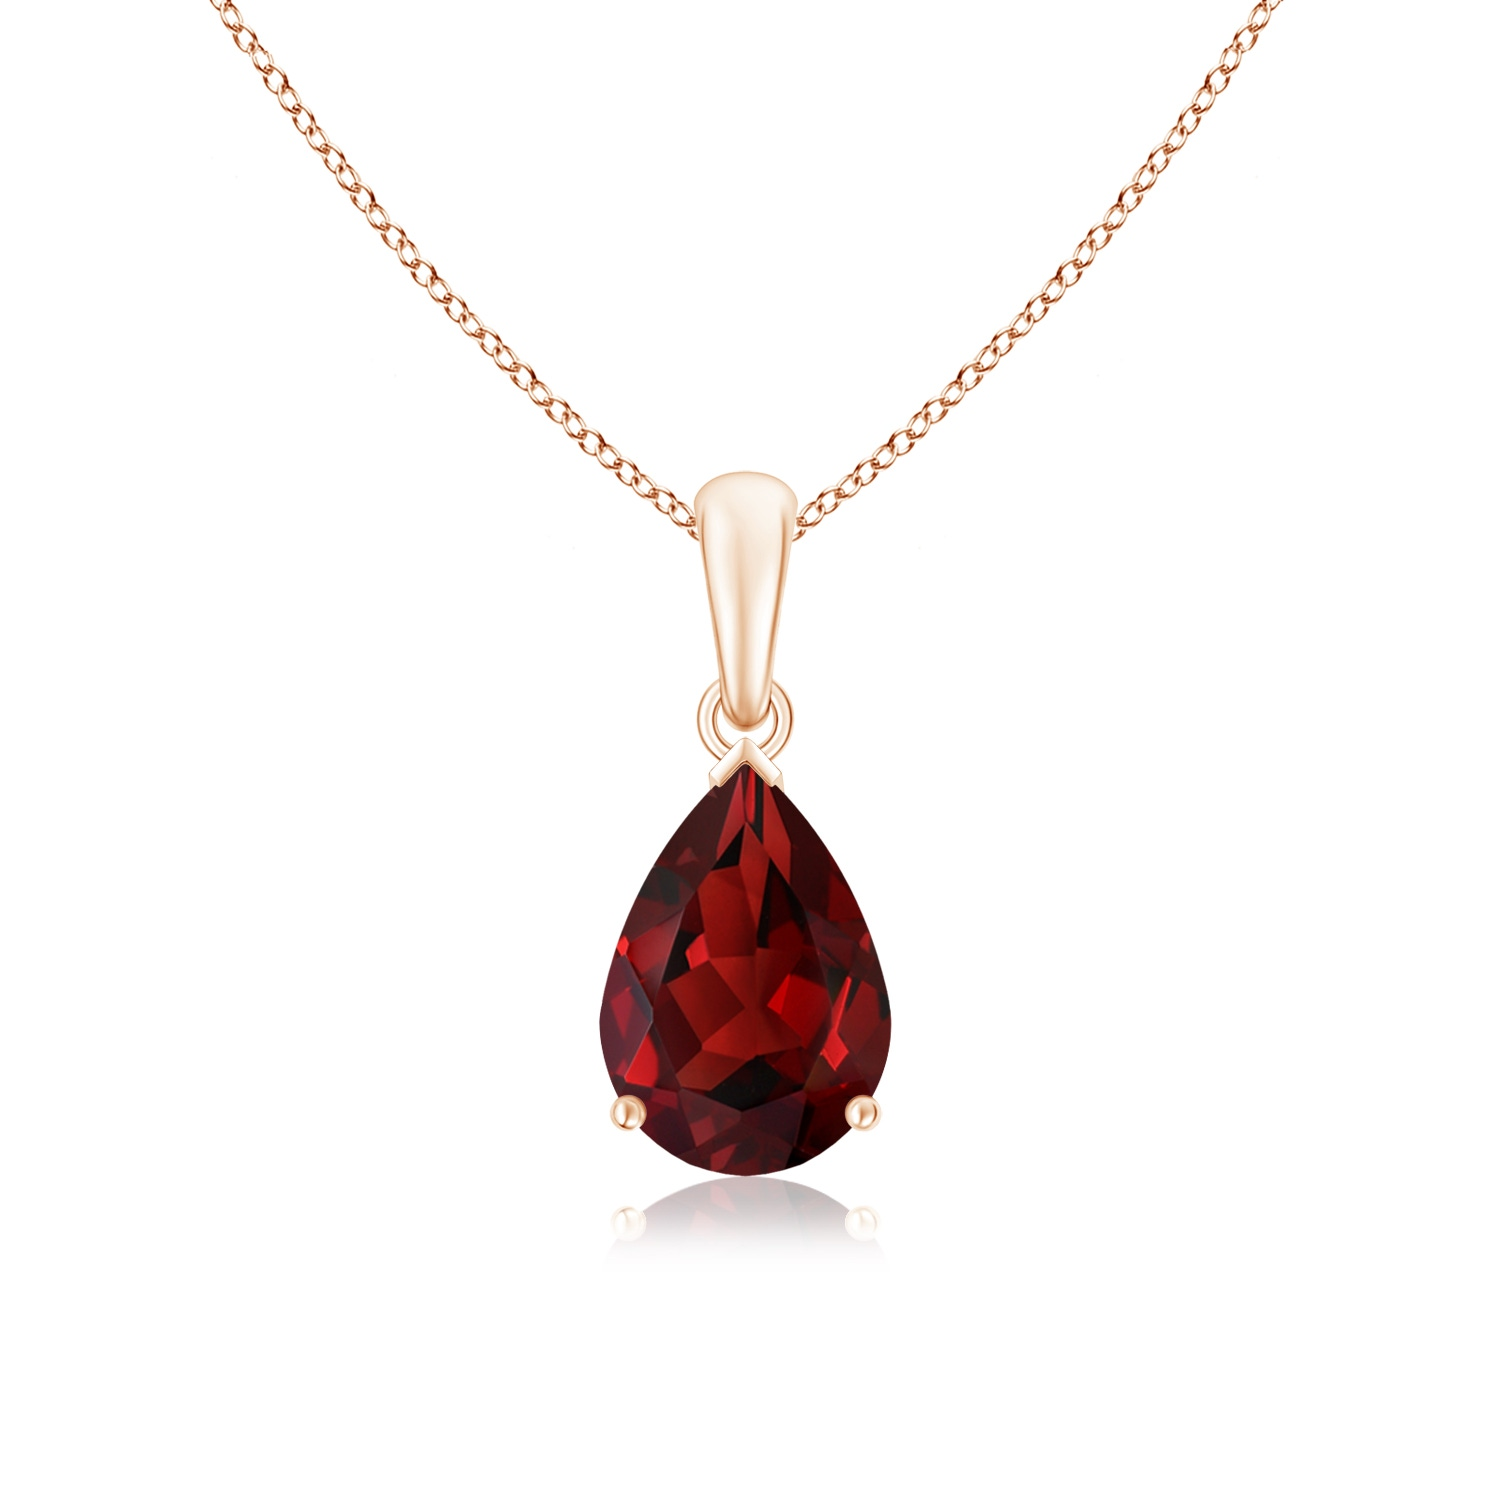

In [36]:
import urllib

Description = "Angara Pendant"
IMAGE_URL="https://assets.angara.com/pendant/sp0448g_n/10x7mm-aaaa-garnet-rose-gold-pendant.jpg?width=1920&quality=95"
urllib.request.urlretrieve(IMAGE_URL, "my_file.jpg")
print("Downloaded")
image_path = "/content/my_file.jpg"
emb = embed(text=Description,image_path=image_path, project=PROJECT)
print(emb)
Image.open(image_path)


### Generate Nearest Neighbors for Test Case 2

In [37]:
response = my_index_endpoint.find_neighbors(
    deployed_index_id=DEPLOYED_INDEX_ID,
    queries=[emb.text_embedding,emb.image_embedding],
    num_neighbors=NUM_NEIGHBORS,
)

response

[[MatchNeighbor(id='01387686b6750b24f043698836dbc108_T', distance=0.6203022003173828),
  MatchNeighbor(id='000644ee3fede4b86059b419383ff013_T', distance=0.6234467029571533),
  MatchNeighbor(id='00b35cdacb0bf4230cb8372774bc0e8c_T', distance=0.6330373883247375),
  MatchNeighbor(id='00ec9f75889b739b7bc4532e1b477014_T', distance=0.6365121006965637),
  MatchNeighbor(id='0097326ca37aee0783bce28eedb8743a_T', distance=0.6379789710044861),
  MatchNeighbor(id='00250f949e316b885c61150158c48e56_T', distance=0.6436767578125),
  MatchNeighbor(id='00fb6491245dde520ca991b11a2a3bfc_T', distance=0.645591139793396)],
 [MatchNeighbor(id='0031ba559767ebd78db849ac6df06257_I', distance=0.5436240434646606),
  MatchNeighbor(id='002cae16ffce99194b37233ae182f62f_I', distance=0.5862588286399841),
  MatchNeighbor(id='00610b5557d458369d1f9a31cf81850f_I', distance=0.5870336294174194),
  MatchNeighbor(id='003fccc2bd5cfb835f14192710eb4990_I', distance=0.6116689443588257),
  MatchNeighbor(id='002810df1681c552e4fc641cd1

### Visualize Nearest Neighbors for Test Case 2

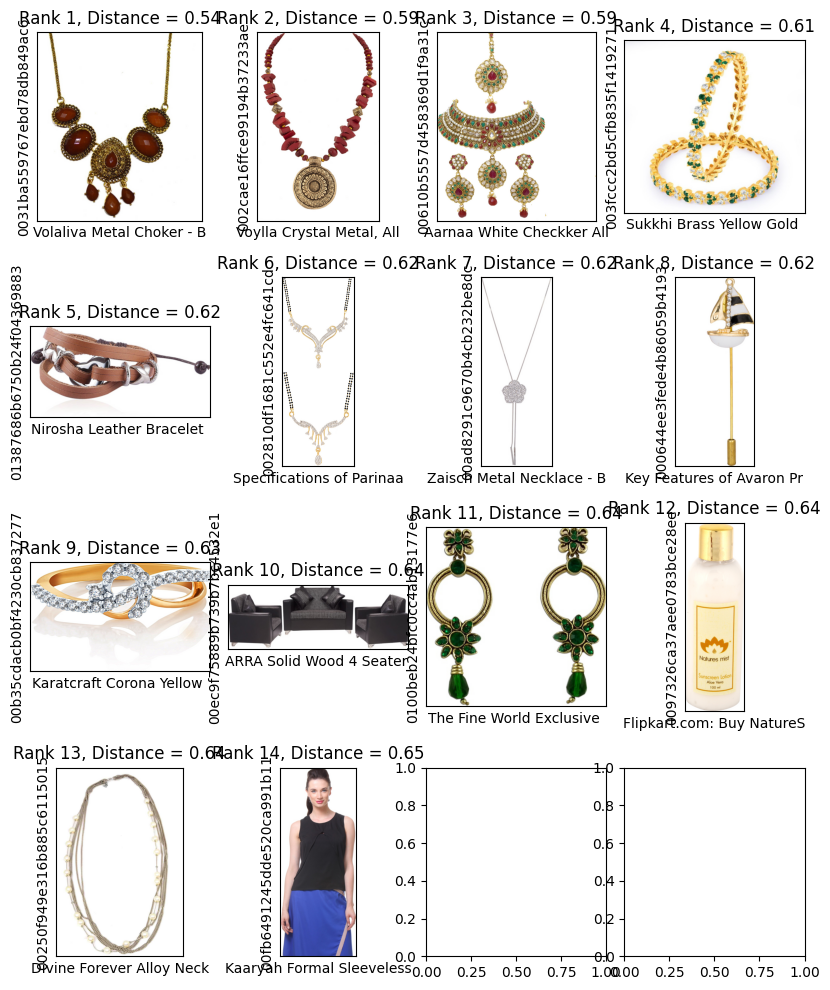

In [38]:
import matplotlib.pyplot as plt
import math
import requests
import ast


def left(s, amount):
    return s[:amount]

neighbors = []

for neighborlist in response:
  for neighbor in neighborlist:
    neighbors.append(neighbor)

# Sort images and scores by descending order of scores and select the top max_images
#sorted_data = sorted(response.nearest_neighbors[0].neighbors, key=lambda x: x.distance, reverse=True)
sorted_data = sorted(neighbors, key=lambda x: x.distance, reverse=False)


# Calculate the number of rows and columns needed to display the images
num_cols = 4
num_rows = math.ceil(len(sorted_data) / num_cols)


# Create a grid of subplots to display the images
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))

# Loop through the top max_images images and display them in the subplots
for i, datalist in enumerate(sorted_data):
    #id = left(datalist.datapoint.datapoint_id,len(datalist.datapoint.datapoint_id)-2)
    id = left(datalist.id,len(datalist.id)-2)
    image_path = ast.literal_eval(df["image"][df["uniq_id"]== id].iloc[0])[0]
    Dist = datalist.distance
    neighbor_description = df["description"][df["uniq_id"]== id].iloc[0]

    # Calculate the row and column index for the current image
    row_idx = i // num_cols
    col_idx = i % num_cols

        # Check if image_path is a remote URL
    if image_path.startswith("http://") or image_path.startswith("https://"):
        ObjectImage = requests.get(image_path)
        image = Image.open(BytesIO(ObjectImage.content))
    else:
        image = Image.open(image_path)

    # Display the image in the current subplot
    axs[row_idx, col_idx].imshow(image, cmap="gray")

    # Set the title of the subplot to the image index and score
    axs[row_idx, col_idx].set_title(f"Rank {i+1}, Distance = {Dist:.2f}")  # noqa
    #axs[row_idx, col_idx].annotate(f"{neighbor_description[:10]}", (1, 1), fontsize=10)
    axs[row_idx, col_idx].set_xlabel(f"{neighbor_description[:25]}")
    axs[row_idx, col_idx].set_ylabel(f"{id[:25]}")


    # Remove ticks from the subplot
    axs[row_idx, col_idx].set_xticks([])
    axs[row_idx, col_idx].set_yticks([])

# Adjust the spacing between subplots and display the plot
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

# Summary of Results

In this notebook, we were able to build a vector store using Vertex Matching Engine for a public repo of product images (Kaggle), Generate embeddings for 2 test cases and retrieve similar product images & descriptions for those 2 test cases.